<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#NB-description" data-toc-modified-id="NB-description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>NB description</a></span></li><li><span><a href="#The-dotsPositions.csv-data" data-toc-modified-id="The-dotsPositions.csv-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The dotsPositions.csv data</a></span></li><li><span><a href="#Write-a-dotsDB-HDF5-file" data-toc-modified-id="Write-a-dotsDB-HDF5-file-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Write a dotsDB HDF5 file</a></span></li><li><span><a href="#PK-Diagnostics" data-toc-modified-id="PK-Diagnostics-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>PK Diagnostics</a></span><ul class="toc-item"><li><span><a href="#Two-PKs-from-artificial-DM" data-toc-modified-id="Two-PKs-from-artificial-DM-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Two PKs from artificial DM</a></span></li><li><span><a href="#Same-two-PKs-from-subject" data-toc-modified-id="Same-two-PKs-from-subject-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Same two PKs from subject</a></span></li></ul></li></ul></div>

# NB description
date: 16 Dec 2019  
AIM = test that with `flipDir = true`, frame-to-frame correlation in ME disappears.

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import seaborn as sns
import h5py     
import os.path

# add location of custom modules to path
sys.path.insert(0,'../modules/')
sys.path.insert(0,'../modules/dots_db/dotsDB/')

# custom modules
import dotsDB as ddb
import motionenergy as kiani_me
import stimulus as stim
import ME_functions as my_me
from basic_functions import *

# The dotsPositions.csv data
Create a labeled dataset for the dots from the `dotsPositions.csv` and `fira.csv` files.

In [2]:
# only one timestamp to deal with
TIMESTAMPS = ('2019_12_13_13_37',)

In [3]:
# where the dotsPositions.csv file resides
DATA_FOLDER = '/home/adrian/SingleCP_DotsReversal/Fall2019/raw/'

The fira dataframe has index ranging from 0 to 819. The next step is to create a "foreign key" to this index into the dots dataframe.

In [4]:
# name of and path to file with labeled dataset (will be created if non-existent)
DOTS_LABELED = '/home/adrian/SingleCP_DotsReversal/Fall2019/processed/test_flipDir.csv'

In [5]:
def custom_label_dots(timestamps, global_labeled_dots_filename, data_folder):
    """
    fetches dots data outputted by MATLAB (the _dotsPositions.csv files) for specified session timestamps, adds
    relevant fira data (join operation) and appends resulting 'labeled_dots' dataframe to the 
    global_labeled_dots_filename.
    :param timestamps: list or tuple of strings of the form '2019_11_05_16_19'
    :param global_labeled_dots_filename: string with full path and filename for global .csv file to write to
    :param data_folder: string with path to folder '.../raw/' where fira and dotsPositions .csv data reside.
    :return: None, but writes to file
    """
    list_of_labeled_dots_dataframes = []
    for ts in timestamps:
        folder = data_folder + ts + '/'
        fira = pd.read_csv(folder + 'completed4AFCtrials_task100_date_' + ts + '.csv')
        dots = pd.read_csv(folder + ts + '_dotsPositions.csv')
        dots = dots[dots['isActive'] == 1]
        del dots['isActive'], dots['taskID'], dots['isCoherent']
        labeled_dots = dots.join(fira, on="trialIx")
        labeled_dots['trueVD'] = labeled_dots['dotsOff'] - labeled_dots['dotsOn']
        labeled_dots['presenceCP'] = labeled_dots['reversal'] > 0
        to_drop = ['trialIndex', 'RT', 'cpRT', 'dirCorrect', 'cpCorrect', 
            'randSeedBase', 'fixationOn', 'fixationStart', 'targetOn',
            'choiceTime', 'cpChoiceTime', 'blankScreen', 'feedbackOn', 
            'cpScreenOn', 'dummyBlank', 'finalDuration', 'dotsOn', 'dotsOff']
        labeled_dots.drop(columns=to_drop, inplace=True)
        to_rename = {
            'duration': 'viewingDuration',
            'direction': 'initDirection',
        }
        labeled_dots.rename(columns=to_rename, inplace=True)
        labeled_dots.dropna(subset=['dirChoice'], inplace=True)
        list_of_labeled_dots_dataframes.append(labeled_dots)
        
    # only write to file if list of dataframes is not empty
    if list_of_labeled_dots_dataframes:
        full_labeled_dots = pd.concat(list_of_labeled_dots_dataframes)
        if os.path.exists(global_labeled_dots_filename):
            full_labeled_dots.to_csv(global_labeled_dots_filename, index=False, mode='a+', header=False)
        else:
            full_labeled_dots.to_csv(global_labeled_dots_filename, index=False, mode='a+', header=True)
            
    return None

In [6]:
# this step with write to the DOTS_LABELED file, which contains labeled dots info necessary to dump to HDF5
if False:
    custom_label_dots(TIMESTAMPS, DOTS_LABELED, DATA_FOLDER)

# Write a dotsDB HDF5 file

In [7]:
dots = pd.read_csv(DOTS_LABELED)

In [8]:
dots.head()

,xpos,ypos,frameIdx,trialIx,taskID,trialStart,trialEnd,dirChoice,cpChoice,initDirection,coherence,finalCPTime,subject,date,probCP,reversal,viewingDuration,trueVD,presenceCP
0,0.257369,0.794932,1,1,100,2.599561e+06,2.599563e+06,0.0,1.0,0,14,0.237288,99.0,2.019121e+11,0.3,0.2,0.25,0.254237,True
1,0.981974,0.196844,1,1,100,2.599561e+06,2.599563e+06,0.0,1.0,0,14,0.237288,99.0,2.019121e+11,0.3,0.2,0.25,0.254237,True
2,0.927031,0.055318,1,1,100,2.599561e+06,2.599563e+06,0.0,1.0,0,14,0.237288,99.0,2.019121e+11,0.3,0.2,0.25,0.254237,True
3,0.523046,0.118572,1,1,100,2.599561e+06,2.599563e+06,0.0,1.0,0,14,0.237288,99.0,2.019121e+11,0.3,0.2,0.25,0.254237,True
4,0.167512,0.929400,1,1,100,2.599561e+06,2.599563e+06,0.0,1.0,0,14,0.237288,99.0,2.019121e+11,0.3,0.2,0.25,0.254237,True


In [9]:
dots.shape

(111985, 19)

In [10]:
dots.columns

Index(['xpos', 'ypos', 'frameIdx', 'trialIx', 'taskID', 'trialStart',
       'trialEnd', 'dirChoice', 'cpChoice', 'initDirection', 'coherence',
       'finalCPTime', 'subject', 'date', 'probCP', 'reversal',
       'viewingDuration', 'trueVD', 'presenceCP'],
      dtype='object')

In [11]:
gb = dots.groupby('trialEnd')  # recall gb.get_group() and gb['frameIdx'].max()

At this stage, I would like to know the max value of `frameIdx` in each trial.

Following cell takes a bit under 9 min

In [12]:
# HDF5 filename (and path) -- will be created if non-existent
h5_filename = '/home/adrian/SingleCP_DotsReversal/Fall2019/processed/test_flipDir.h5'
if False:  # just a failsafe not to run this cell by mistake
    # Recall func is called twice the first time!
    _ = gb.apply(write_dots_to_file, h5_filename)
    
    # need to go in manually and delete the first entry in the dataset corresponding to 
    # the first group element gb.groups.keys()[0] 
    single_row = dots[dots['trialEnd']==list(gb.groups.keys())[0]]
    pb_dset_name, vals = get_group_name(single_row)
    pb_dset_name += '/px'
    f = h5py.File(h5_filename, 'r+')  # read/write
    d = f[pb_dset_name]
    d = d[1:]  # override first trial
    f.__delitem__(pb_dset_name)
    f[pb_dset_name] = d
    f.close()

# PK Diagnostics

In [13]:
# OPTIONS AND CONSTANTS
%matplotlib inline

sns.set(style="darkgrid", context="poster")
TITLE_FS = 22
AXES_FS = 22
plt.rcParams.update({'font.size': AXES_FS}) # font size on axes
plt.subplots_adjust(wspace=0.5) # horizontal space between panels

<Figure size 432x288 with 0 Axes>

In [14]:
obj_names, db_info = my_me.get_object_names_in_db(h5_filename)

In [15]:
CYLINDERS = (
    (('coh', (0,), 'vd', (400,), 'cp', (False,), 'subject', (99,), 'dir', ('left',)), False),     # 0
    (('coh', (0,), 'vd', (400,), 'cp', (False,), 'subject', (99,), 'dir', ('right',)), False),     # 1
    (('coh', (0,), 'vd', (400,), 'cp', (False,), 'subject', (99,)), True),     # 2
    (('coh', (0,), 'vd', (400,), 'cp', (True,), 'subject', (99,), 'dir', ('left',)), False),     # 3
    (('coh', (0,), 'vd', (400,), 'cp', (True,), 'subject', (99,), 'dir', ('right',)), False),     # 4
    (('coh', (0,), 'vd', (400,), 'cp', (True,), 'subject', (99,)), True),     # 5
)
first_args = db_info, 50, CYLINDERS, obj_names, h5_filename

## Two PKs from artificial DM

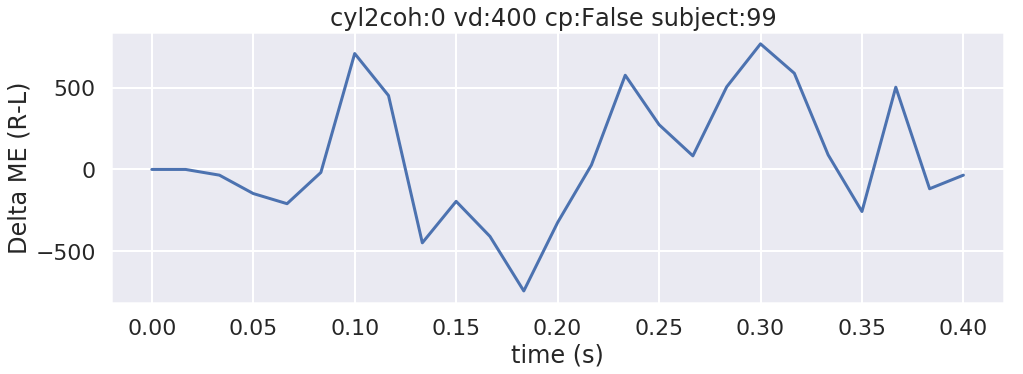

In [16]:
my_me.plot_cyl(*first_args, 2, real=False)

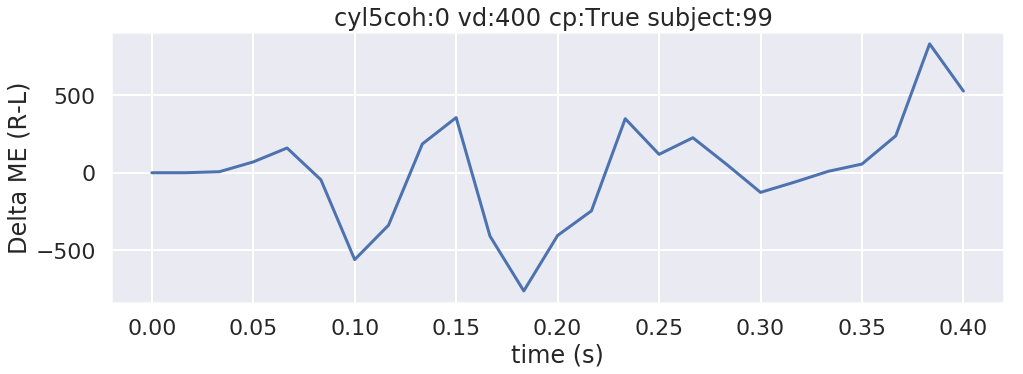

In [17]:
my_me.plot_cyl(*first_args, 5, real=False)

## Same two PKs from subject

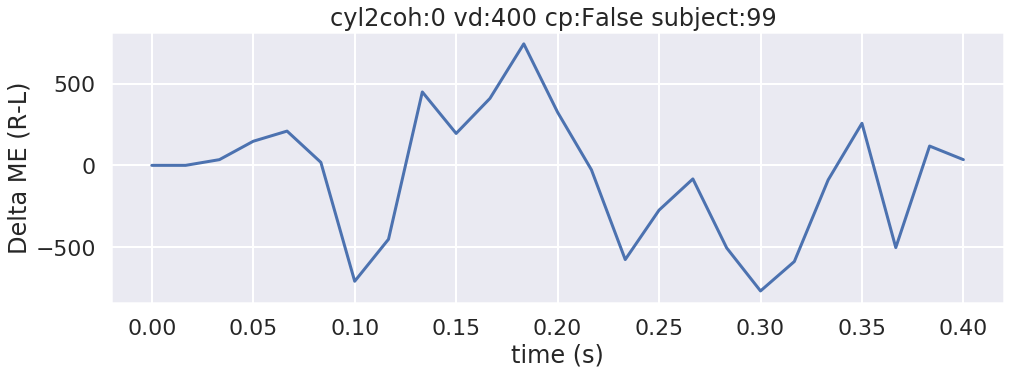

In [18]:
my_me.plot_cyl(*first_args, 2, real=True)

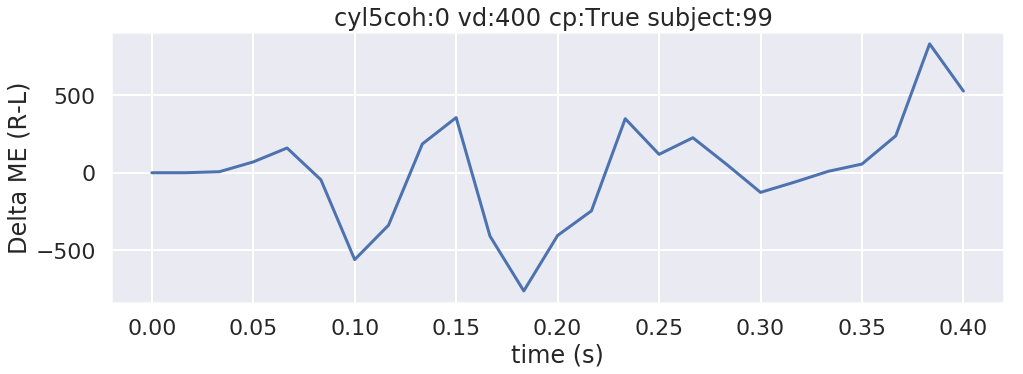

In [19]:
my_me.plot_cyl(*first_args, 5, real=True)